<a href="https://colab.research.google.com/github/random-words/colab-notebooks/blob/main/05__transfer_learning_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-02-03 21:58:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-02-03 21:58:29 (59.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

# 101 Food Classes

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2025-02-03 21:58:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.207, 142.250.145.207, 74.125.128.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  39.3MB/s    in 44s     

2025-02-03 21:59:21 (35.2 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
unzip_data("101_food_classes_10_percent.zip")

In [7]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [8]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_bolognese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/filet_mignon'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/frozen_yogurt'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and 250 images in 

In [9]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode="categorical")
test_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                               image_size=IMG_SIZE,
                                                                               label_mode="categorical",
                                                                               shuffle=False) # don't shuffle test data for pred analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Training model

In [10]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"

In [11]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [12]:
# Create data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
    # layers.Rescaling(1/255.) # don't needed with our model
], name="data_augmentation")

In [13]:
# Build model

base_model = tf.keras.applications.EfficientNetV2B0(include_top=False) # backbone model
base_model.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,), name="input_layer")
x = data_augmentation(inputs) # augment images (only on training phase)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x) # compress data tensors into feature vector
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax",
                       name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [14]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b0 (Functional)       │ (None, None, None, 1280)    │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [15]:
# Compile model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [16]:
initial_epochs = 5

In [17]:
# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=initial_epochs,
                                           steps_per_epoch=len(train_data_all_10_percent),
                                           validation_data=test_data_all_10_percent,
                                           validation_steps=int(0.15 * len(test_data_all_10_percent)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 798s 3s/step - accuracy: 0.1315 - loss: 4.1044 - val_accuracy: 0.4367 - val_loss: 2.6975
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 810s 3s/step - accuracy: 0.4186 - loss: 2.6007 - val_accuracy: 0.4894 - val_loss: 2.2087
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 791s 3s/step - accuracy: 0.4872 - loss: 2.1857 - val_accuracy: 0.5188 - val_loss: 2.0078
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 803s 3s/step - accuracy: 0.5226 - loss: 1.9706 - val_accuracy: 0.5257 - val_loss: 1.9188
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 866s 3s/step - accuracy: 0.5446 - loss: 1.8353 - val_accuracy: 0.5376 - val_loss: 1.8312


In [18]:
feature_extraction_results = model.evaluate(test_data_all_10_percent)
feature_extraction_results

  2/790 ━━━━━━━━━━━━━━━━━━━━ 21:15 2s/step - accuracy: 0.0859 - loss: 3.1216

KeyboardInterrupt: 

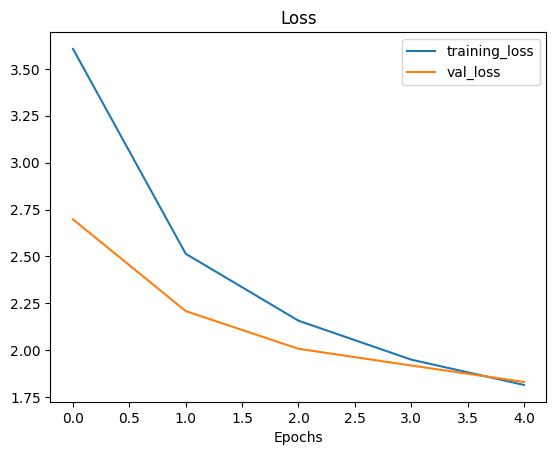

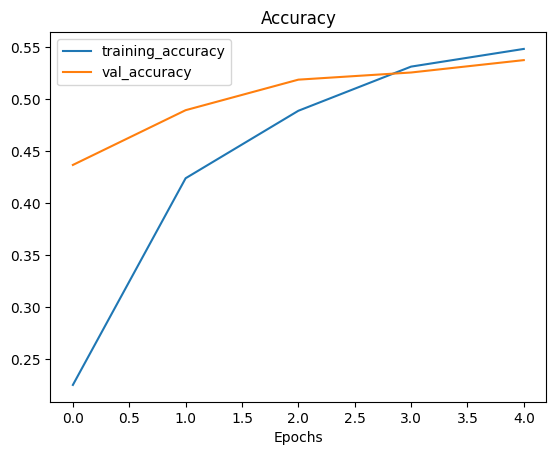

In [19]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [28]:
# Unfreeze some layers
base_model.trainable = True

# Freeze all except last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [29]:
# Recompile the model (with lower learning rate)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [30]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling2d True
output_layer True


In [31]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [32]:
fine_tune_epochs = initial_epochs + 5

In [ ]:
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data_all_10_percent,
                                                     validation_steps=int(0.15 * len(test_data_all_10_percent)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 840s 3s/step - accuracy: 0.5573 - loss: 1.9529 - val_accuracy: 0.5212 - val_loss: 1.9420
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - accuracy: 0.5928 - loss: 1.7765 - val_accuracy: 0.5299 - val_loss: 1.8530
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 857s 4s/step - accuracy: 0.6125 - loss: 1.6767 - val_accuracy: 0.5373 - val_loss: 1.7997
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6216 - loss: 1.6058

In [ ]:
all_classes_10_percent_fine_tune_results = model.evaluate(test_data_all_10_percent)
all_classes_10_percent_fine_tune_results

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=initial_epochs)

## Model Deployment

In [ ]:
# Save model
model.save("saved_models/model_1")

In [ ]:
# Load model
loaded_model = tf.keras.models.load_model("saved_models/model_1")

In [ ]:
# Evaluate model and compare it to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data_all_10_percent)
loaded_model_results

In [ ]:
# results should be very similar
all_classes_10_percent_fine_tune_results

## Model Evaluation

In [ ]:
import tensorflow as tf

# download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

In [ ]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
# load in saved model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# evaluate downloaded model
downloaded_model_results = model.evaluate(test_data_all_10_percent)
downloaded_model_results

## Making predictions with trained model

In [ ]:
preds_probs = model.predict(test_data_all_10_percent, verbose=1)

In [ ]:
len(test_data_all_10_percent)

In [ ]:
len(preds_probs)

In [ ]:
preds_probs.shape

In [ ]:
preds_probs[:10]

In [ ]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

In [ ]:
preds_probs[0].argmax()

In [ ]:
test_data_all_10_percent.class_names

In [ ]:
test_data_all_10_percent.class_names[preds_probs[0].argmax()]

In [ ]:
# Get pred classes of each label
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

In [ ]:
len(pred_classes)

In [ ]:
test_data_all_10_percent

In [ ]:
# To get test labels we need to unravel our test_data Batch
y_labels = []
for images, labels in test_data_all_10_percent.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

In [ ]:
len(y_labels)